# Global sensitivity analysis. A flood case study.

In [1]:
## Computer experiments course.
## O. Roustant (INSA Toulouse), with contributions from B. Iooss (EDF & IMT)

We consider a simplified first model simulating flooding events.
The model has $8$ input random variables, viewed as random variables:

* $X_{1} = Q$, Maximal annual flowrate (m$^3$/s), Gumbel ${\mathcal G}(1013, 558)$ truncated on $[500 , 3000 ]$
* $X_{2}=K_s$, Strickler coefficient, Normal ${\mathcal N}(30, 8^2)$ truncated on $[15 , +\infty [$
* $X_{3} = Z_v$, River downstream level (m), Triangular ${\mathcal T}(49, 51)$ 
* $X_{4} = Z_m$, River upstream level (m), Triangular  ${\mathcal T}(54, 56)$
* $X_{5} = H_d$, Dyke height (m),  Uniform ${\mathcal U}[7, 9]$ 
* $X_{6} = C_b$, Bank level (m), Triangular ${\mathcal T}(55, 56)$
* $X_{7} = L$, River stretch (m), Triangular ${\mathcal T}(4990, 5010)$
* $X_{8} = B$, River width (m), Triangular ${\mathcal T}(295, 305)$

We consider two variables of interest. First, the maximal annual overflow $S$ (in meters), obtained from simplified hydro-dynamical equations of Saint-Venant:
\begin{equation}
S = \left(\frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} + Z_v - H_d - C_b \,.
\end{equation}
Secondly, the cost (in million euros) of the damage on the dyke $Y$, depending on $S$, written as:
\begin{equation}
Y = 1_{S>0} +  \left[0.2 + 0.8\left( 1-\exp^{-\frac{1000}{S^4}}\right) \right] 1_{S \leq 0} + \frac{1}{20}\left(H_d 1_{H_d>8} + 8 1_{H_d \leq 8} \right) \,,
\end{equation}
where $1_{A}(x)$ is the indicator function which is equal to 1 for $x \in A$ and 0 otherwise.
The aim is to perform a global sensitivity analysis for $S$ and $Y$. In particular, we would like to detect the non-essential input variables and the active subspaces.


In [1]:
# Input names
floodInputNames <- c("Q", "Ks", "Zv", "Zm", "Hd", "Cb", "L", "B")
floodOutputNames <- c("Subverse", "Cost")

# Flood model
flood <- function(X, ans = 0){ 
    # ans = 1 gives Overflow output; ans = 2 gives Cost output; ans=0 gives both
    mat <- as.matrix(X, ncol = 8)
    if (ans == 0) {
        output <- matrix(NA, nrow(mat), 2)
    } else { 
        output <- rep(NA, nrow(mat))
    }
    for (i in 1:nrow(mat)){
        H <- (mat[i, 1] / (mat[i, 2] * mat[i, 8] * sqrt((mat[i, 4] - mat[i, 3]) / mat[i, 7])))^0.6
        S <- mat[i, 3] + H - mat[i, 5] - mat[i, 6] 
    if (S > 0){ 
        Cp <- 1
    } else { 
        Cp <- 0.2 + 0.8 * (1 - exp(- 1000 / S^4))
    }
    if (mat[i, 5] > 8){
        Cp <- Cp + mat[i, 5] / 20 
    } else { 
        Cp = Cp + 8 / 20
    }
    if (ans == 0){
        output[i, 1] <- S ;
        output[i, 2] <- Cp ;
    }
    if (ans == 1) output[i] <- S
    if (ans == 2) output[i] <- Cp 
    }
    return(output)
}

In [2]:
# Function for flood model inputs sampling
library(sensitivity) # (truncated) Gumbel law and truncated Normal law
library(triangle) # Triangular law

floodSample <- function(size){
    X <- matrix(NA, size, 8)
    X[, 1] <- rgumbel.trunc(size, loc = 1013, scale = 558, min = 500, max = 3000)
    X[, 2] <- rnorm.trunc(size, mean = 30, sd = 8, min = 15)
    X[, 3] <- rtriangle(size, a = 49, b = 51)
    X[, 4] <- rtriangle(size, a = 54, b = 56)
    X[, 5] <- runif(size, min = 7, max = 9)
    X[, 6] <- rtriangle(size, a = 55, b = 56)
    X[, 7] <- rtriangle(size, a = 4990, b = 5010)
    X[, 8] <- rtriangle(size, a = 295, b = 305)
    return(X)
}

Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr



# Questions

First select the output 1 (Subverse). The aim is to perform a global sensitivity analysis (GSA) in order the discover what are the most influential inputs, the unessential ones, to visualize the input-output relationship and to quantify the importance of the inputs on the outputs. For the sake of reproducibility, fix the seed to 0 each time a random sampling is done (in R: set.seed(0)).

## GSA with an unlimited budget
We first consider the case of an unlimited budget. Thus we choose a large sample size $N = 5\,000$ (for instance). 

1. Simulate a sample of size $N$ of the inputs by Monte Carlo and compute the corresponding output (use the R functions "floodSample" and "flood"). Store the sample in a matrix called $X$, and the output values in a vector called $Y$. Plot the output versus the inputs. Comment the results: what is the form of the input-output relationship?  


2. Estimate the global mean. Estimate the main effects with local polynomial regression (use the R function "loess"). Adapt the previous matrix of graphs to superimpose the main effects.  


3. Estimate the Sobol indices with the R function "sobolJansen" (package "sensitivity"). Plot the results and comment them: what are the most influential variables? Are there interactions? Between which variables?


## GSA with a limited budget
Now we want to retrieve these results with a limited budget, say $n = 10d$ where $d = 8$ is the inputs dimension.
To reach that goal, we do three steps: (a) create a design of experiments, (b) build a Gaussian process metamodel, (c) perform the GSA on the metamodel. We adopt a "goal-oriented" strategy, meaning that we aim the metamodel to be accurate when the probability distribution of the inputs is taken into account.

4. We first choose carefully a design of experiments of size $n$. 
a) What are the main drawbacks of Monte Carlo sampling with a small sample size? Explain why it is not possible to use a full factorial design here ; even if it were possible, recall why it is not a good idea, in relation to question 3.   
b) To overcome these drawbacks, create a space-filling design as a Sobol sequence. This first design is well suited for uniform distributions. Use the quantile transformation to deduce a design of experiments, called $Xtrain$, such that marginal distribution of the inputs is correct; for that create a function called "floodQuantile" by adapting the function "floodSample" above. Visualize the result with a scatterplot (with histograms on the diagonal) and compare (visually) with Monte Carlo sampling (function "floodSample").  

5. Compute the output values corresponding to $Xtrain$ and store them in a vector called $Ytrain$. Estimate a Gaussian process metamodel (or kriging model) with function "km" (R package "DiceKriging"). What is the kernel used by default? Comment briefly the model validity by using the diagnostics proposed in function "plot". Compute its performance on the sample $X$, used as a test set: plot the predicted values versus the true ones (stored in $Y$). Compute the $Q^2$ criterion defined by 
$$Q^2(Y, \hat{Y}) = 1 - \frac{\Vert Y - \hat{Y} \Vert^2}{\Vert Y - \bar{Y} \Vert^2} $$
where the norm is the Euclidean norm, and $\bar{Y}$ is the mean of $Y$. Thus $Q^2$ compares the performance of the predictions $\hat{Y}$ compared to what would be predicted by the constant prediction equal to the mean.

6. Compare the performance of the GP metamodel with a naive linear model (first-order polynomial). When the output is the cost, add $H_d^2$ to the covariates of this linear model (explain why it is reasonable). For that, plot the predictions versus the true values, and compute the $Q^2$ criterion as well.

7. Perform a GSA on the mean of the GP metamodel (kriging mean) by doing questions 1-3 for it. Compare these results to the unlimited budget case.

## Metamodeling improvements and physics-informed Gaussian process

To improve the metamodeling step, we bring some information contained in the equations defining the subverse and the cost.

8. Consider the output "subverse". Play with function 'km' in order to add a linear trend to the GP model. Check that this model outperforms the basic GP, by plotting the prediction on the test set (here $X$) versus the true value, and computing the $Q^2$ criterion. Redo question 7 for this model. Comment?

9. Knowing the equation of the ouput "cost", we see that a suitable GP should have the form 
$$Y(S, H_d) = Y_1(S) + Y_2(H_d)$$
Assuming that $Y_1, Y_2$ are independent Gaussian processes with kernels $k_1, k_2$, what form should have the kernel of $Y$? Estimate this new GP with function "kmAdditive", from the R package fanovaGraph, still using $Xtrain$ as a desing of experiments. Check that this model outperforms the basic GP. Compare also with a GP depending on $S$ and $H_d$. However, explain why it seems difficult to use this approach for global sensitivity analysis with respect to the original variables.

## At least one theoretical computation

10. For the output "S", compute theoretically the main effect with respect to the variable $H_d$. Compare with 3)a). Same question for $C_b$.


## Starter

In [3]:
myOutput <- 1  # 1 for subverse, 2 for cost

## Question 1

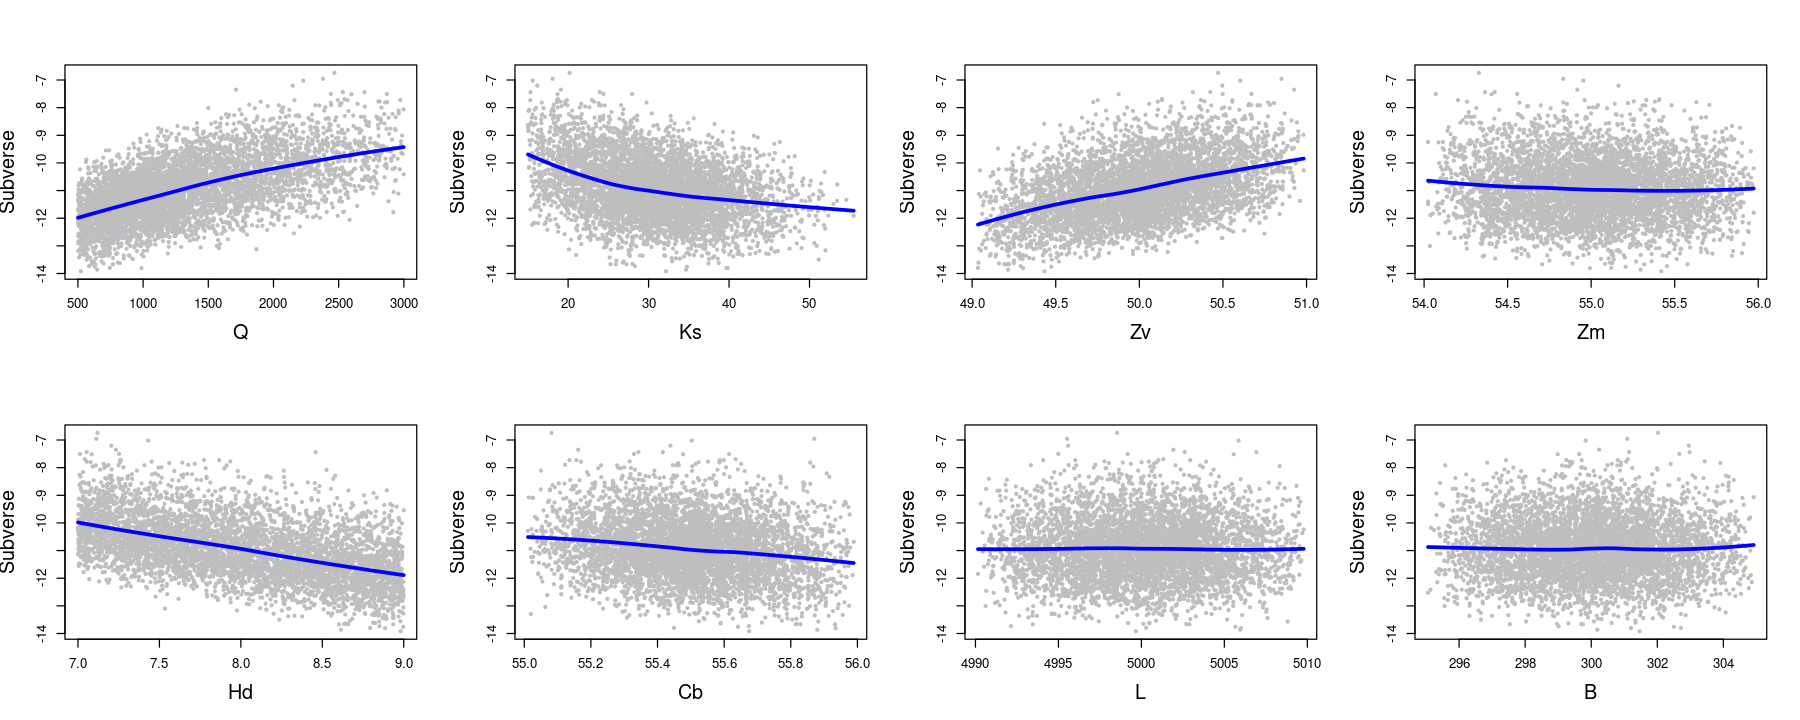

In [4]:
N = 5000 
set.seed(0)
X = floodSample(N)
colnames(X) = floodInputNames
Y = flood(X, ans = myOutput)

par(mfrow = c(2, 4))
options(repr.plot.width = 15, repr.plot.height = 6)

# the next lines must be slightly adapted, there are not exactly suited to represent the main effects
for (i in 1:8){
    plot(Y ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames[myOutput], 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- loess(Y ~ X[, i])  #interpolation des points 
    t <- seq(from = min(X[, i]), to = max(X[, i]), length = 100) #on ne plot qu'à partir de là où il y a des pts
    lines(t, predict(ss, t), col = "blue", lwd = 3)
}


### Comment the results: what is the form of the input-output relationship? 

Certaines fonctions coûteuses "Subverse" varient linéairement en fonction des variables d'entrées stockées dans X.
Nous remarquons que la fonction S semble varier quadratiquement en fonction de la variable Ks.
Nous observons également que les variables L, B, et Zm n'affectent pas la fonction coûteuse (elles restent constante).

## Question 2

Estimate the global mean. Estimate the main effects with local polynomial regression (use the R function "loess"). Adapt the previous matrix of graphs to superimpose the main effects.  

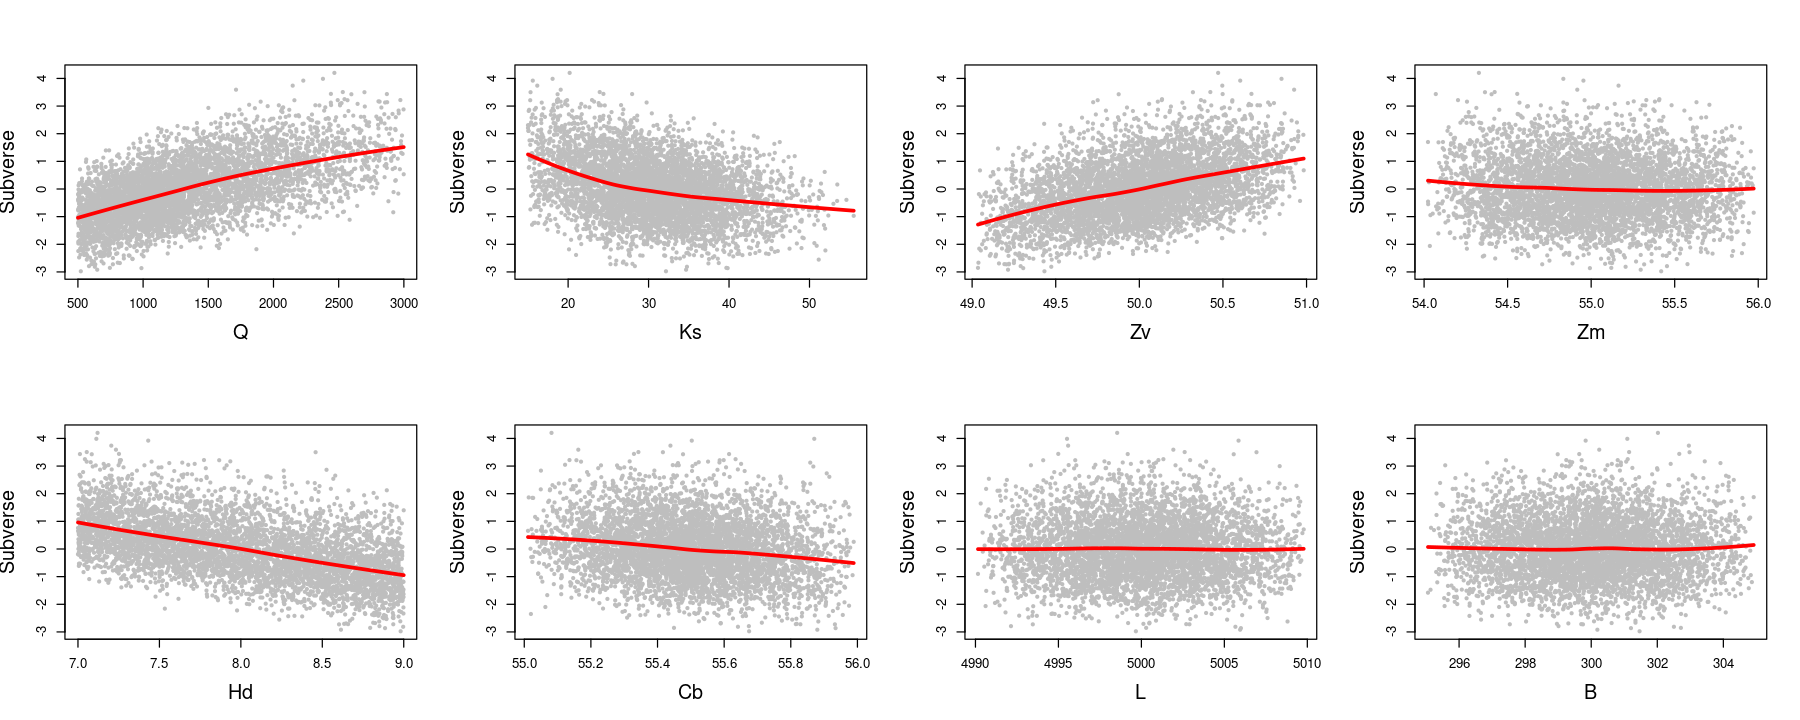

In [5]:
# Help for questions 1 and 2
N = 5000 
set.seed(0)
X = floodSample(N)
colnames(X) = floodInputNames
Y = flood(X, ans = myOutput)
Y_mean = mean(Y)
par(mfrow = c(2, 4))
options(repr.plot.width = 15, repr.plot.height = 6)

# the next lines must be slightly adapted, there are not exactly suited to represent the main effects
for (i in 1:8){
    plot(Y - Y_mean ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames[myOutput], 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- loess(Y - Y_mean ~ X[, i])  #interpolation des points 
    #ss2 <- loess(Y ~ X[, i])
    t <- seq(from = min(X[, i]), to = max(X[, i] ), length = 100)
    lines(t, predict(ss, t), col = "red", lwd = 3)
    #lines(t, predict(ss2, t), col = "blue", lty=2)
}

Graphiques représentant nos données centrées (elles ne l'étaient pas auparavant).

## Question 3

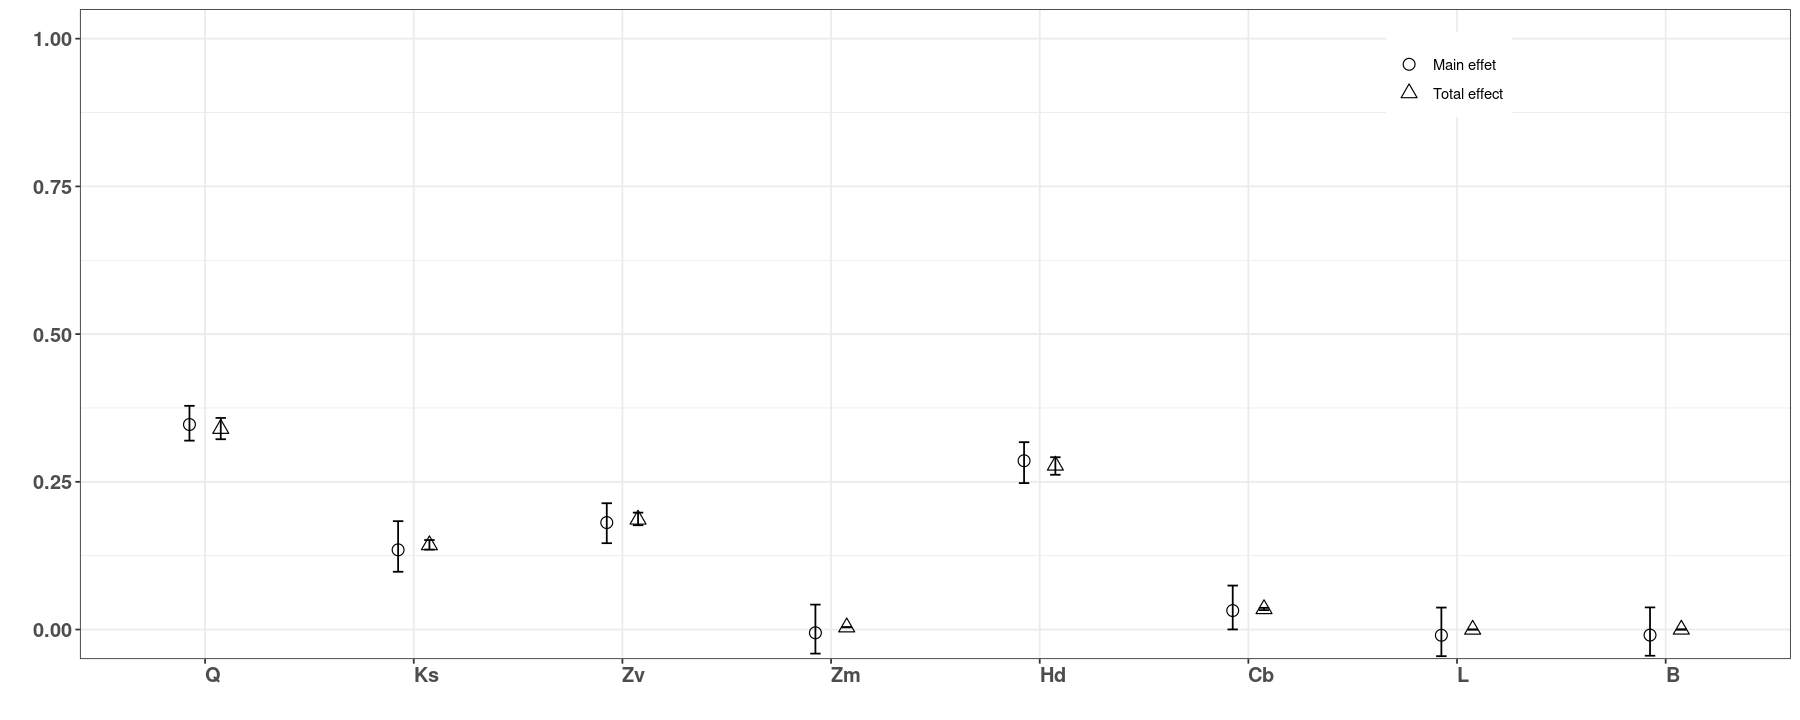

In [6]:
library(boot)
# we use a pick-freeze formula (Sobol Jansen), which requires two samples
X1 <- floodSample(N)
X2 <- floodSample(N)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis

SAresult <- soboljansen(model = flood, X1, X2, nboot = 100, ans = myOutput)
totalIndex <- SAresult$T$original; names(totalIndex) <- floodInputNames
sobolIndex <- SAresult$S$original; names(sobolIndex) <- floodInputNames

library(ggplot2)
ggplot(SAresult)

Estimate the Sobol indices with the R function "sobolJansen" (package "sensitivity"). Plot the results and comment them: what are the most influential variables? Are there interactions? Between which variables?

Dans la suite, nous appelerons la fonction coûteuse la fonction S.

Ici, on observe une estimation des indices de Sobol ainsi qu'une estimation des indices de Sobol totaux pour la fonction S. On remarque que les variables Q et Hd expliquent plus de 25% de la variance. Les variables Ks et Zv expliquent quant à elles environ 10% de la variance. Ces quatre variables sont celles qui expliquent le mieux la fonction S. Les variables Zm, Cb, L et B, à l'inverse, sont celles qui expliquent le moins la fonction S puisque la variance est proche de 0. Cela correspond à ce que nous avons vu dans la question 1. En effet, nous avions vu que la fonction S était constante par rapport aux paramètres Zm, Cb, L et B. Nous pourrions donc ne pas les prendre en compte pour la suite.

De plus, puisque les main effects et les total effect sont au même niveau dans le graphique pour chacune des variables, les facteurs individuels n'ont pas d'interaction significative les uns avec les autres. L'impact de chacune des variables sur la fonction S n'est dû qu'à son effet direct. Il n'y a pas d'interactions entre les variables.

## Question 4

Le chargement a nécessité le package : rngWELL

This is randtoolbox. For an overview, type 'help("randtoolbox")'.


Attachement du package : ‘randtoolbox’


L'objet suivant est masqué depuis ‘package:sensitivity’:

    sobol




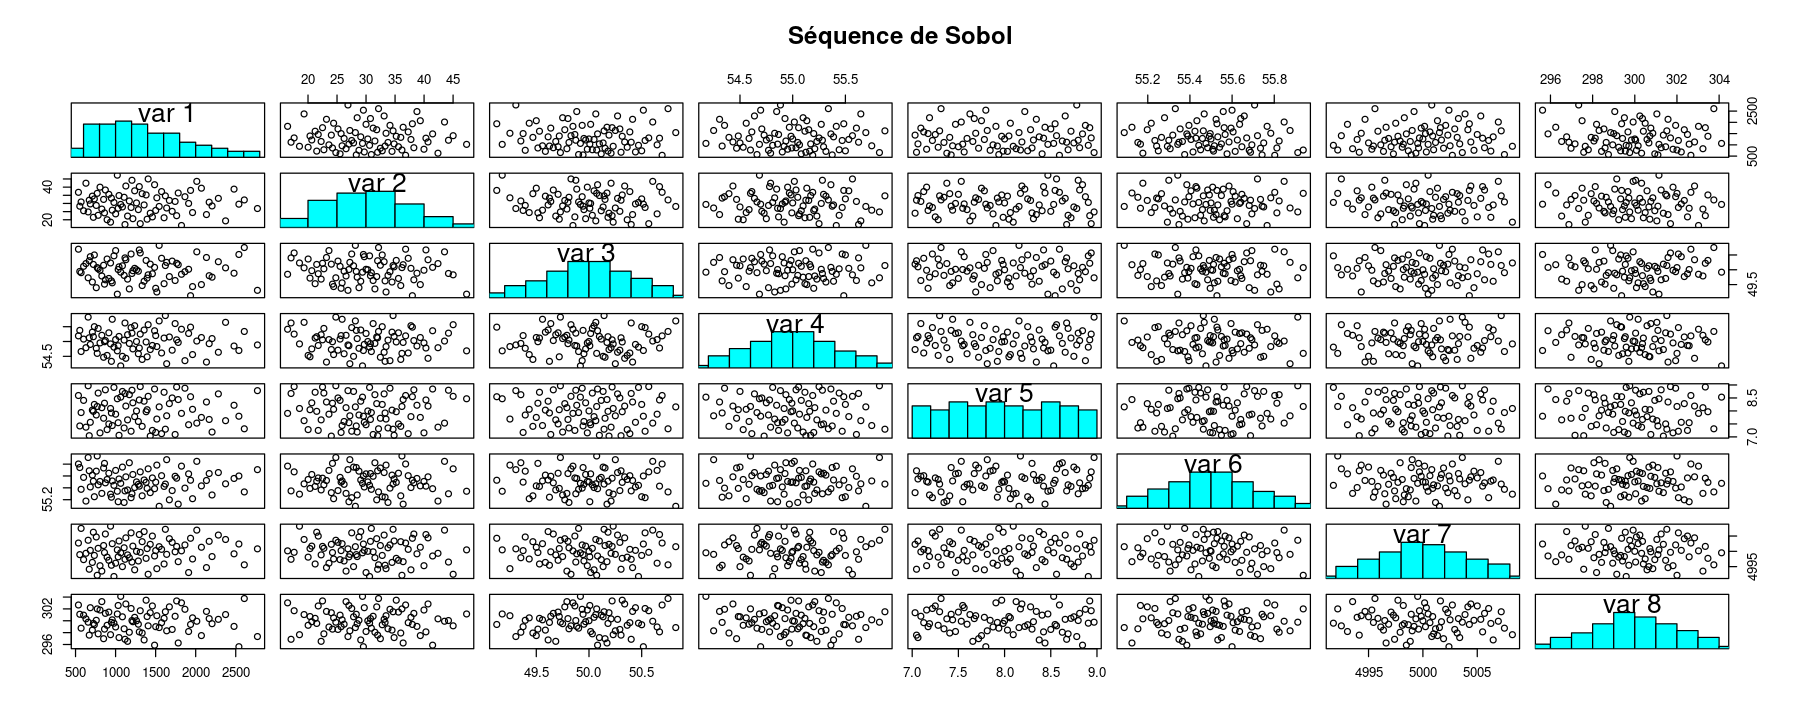

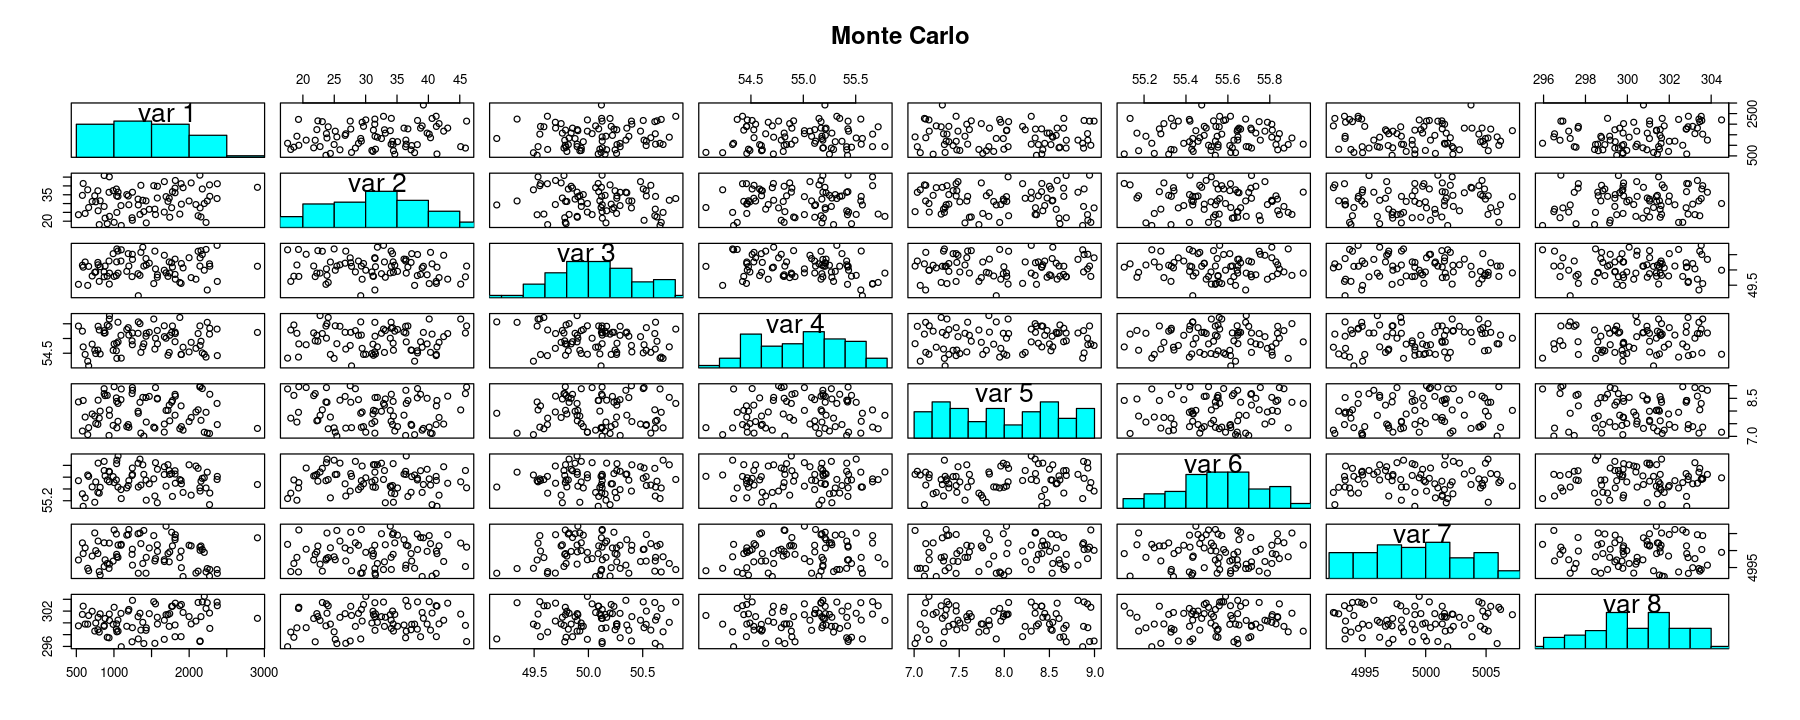

In [7]:
library(DiceDesign)
library(randtoolbox)

# Define the function to perform quantile transformation
floodQuantile <- function(M) {
  X <- matrix(NA, nrow = nrow(M), ncol = ncol(M))
  X[, 1] <- qgumbel.trunc(M[, 1], loc = 1013, scale = 558, min = 500, max = 3000)
  X[, 2] <- qnorm.trunc(M[, 2], mean = 30, sd = 8, min = 15, max = Inf)
  X[, 3] <- qtriangle(M[, 3], a= 49, b = 51)
  X[, 4] <- qtriangle(M[, 4], a= 54, b = 56)
  X[, 5] <- qunif(M[, 5], min = 7, max = 9)
  X[, 6] <- qtriangle(M[, 6], a = 55, b = 56)
  X[, 7] <- qtriangle(M[, 7], a = 4990, b = 5010)
  X[, 8] <- qtriangle(M[, 8], a = 295, b = 305)

  return(X)
}

# scatterplot with histograms on the diagonal (from the helppage of pairs)
panel.hist <- function(x) {
  usr <- par("usr")
  par(usr = c(usr[1:2], 0, 1.5))
  h <- hist(x, plot = FALSE)
  breaks <- h$breaks; nB <- length(breaks)
  y <- h$counts; y <- y / max(y)
  rect(breaks[-nB], 0, breaks[-1], y, col = "cyan")
}
S = sobol(n=80, dim=8)
X_train <- floodQuantile(S)
# Graph avec la méthode de la séquence de Sobol
pairs(X_train, diag.panel = panel.hist, main = "Séquence de Sobol")

# Graph avec méthode de Monte Carlo
pairs(floodSample(80), diag.panel = panel.hist, main = "Monte Carlo")

Questions:

a) What are the main drawbacks of Monte Carlo sampling with a small sample size? Explain why it is not possible to use a full factorial design here ; even if it were possible, recall why it is not a good idea, in relation to question 3.   
b) To overcome these drawbacks, create a space-filling design as a Sobol sequence. This first design is well suited for uniform distributions. Use the quantile transformation to deduce a design of experiments, called $Xtrain$, such that marginal distribution of the inputs is correct; for that create a function called "floodQuantile" by adapting the function "floodSample" above. Visualize the result with a scatterplot (with histograms on the diagonal) and compare (visually) with Monte Carlo sampling (function "floodSample"). 

Response:

a) Les plus grands inconvénients d'un échantillion de Monte Carlo avec une taille d'échantillon (n) faible sont :
- la convergence de la méthode de Monte Carlo est en O($\frac{1}{\sqrt(n)}$) (donc la convergence de cette méthode est lente). Donc pour n petit, cette méthode peut entrainer de grandes erreurs et risque de ne pas converger,
- la méthode de Monte Carlo peut nécessiter un grand nombre d'itérations, surtout si n est petit,
- si n est petit, on peut avoir des estimations biaisées car l'échantillon utilisé n'est pas représentatif de la population.

De plus, il n'est pas possible d'utiliser un "full factorial design" ici car ce design implique un grand nombre de facteurs avec plusieurs niveaux et avec le nombre de variables que nous avons, il faudrait réaliser un grand nombre de simulations (contradiction avec le fait que n soit faible).

Dans tous les cas, d'après la question 3, ce type de design ne serait pas une bonne idée car il y a des variables inactives dans notre exemple et nous aurions donc des redondances sur nos points (plusieurs points qui ne définiraient au final qu'un même point après application de S).


b) Nous remarquons qu'avec la méthode de Monte Carlo, les lois des variables obtenues sont plus loins de la réalité qu'avec la méthode de la séquence de Sobol. C'est normal car la séquence de Sobol est une séquence de faible discrépence. Autrement dit, ce design garantie une bonne approximation de l'intégrale de f, ce qui est idéal pour un Design of Experiment (DoE).

## Question 5


Compute the output values corresponding to $Xtrain$ and store them in a vector called $Ytrain$. Estimate a Gaussian process metamodel (or kriging model) with function "km" (R package "DiceKriging"). What is the kernel used by default? Comment briefly the model validity by using the diagnostics proposed in function "plot". Compute its performance on the sample $X$, used as a test set: plot the predicted values versus the true ones (stored in $Y$). Compute the $Q^2$ criterion defined by 
$$Q^2(Y, \hat{Y}) = 1 - \frac{\Vert Y - \hat{Y} \Vert^2}{\Vert Y - \bar{Y} \Vert^2} $$
where the norm is the Euclidean norm, and $\bar{Y}$ is the mean of $Y$. Thus $Q^2$ compares the performance of the predictions $\hat{Y}$ compared to what would be predicted by the constant prediction equal to the mean.



optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  4469.454 61.69289 3.396447 3.396447 3.875 1.698223 32.92893 16.98223 
  - best initial criterion value(s) :  -21.48523 -31.69207 -44.58431 -46.48315 -48.33428 

N = 8, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       21.485  |proj g|=       3.9243
At iterate     1  f =       10.833  |proj g|=        3.3964
At iterate     2  f =       1.4644  |proj g|=        3.1882
At iterate     3  f =      -2.5314  |proj g|=        2.4705
At iterate     4  f =      -7.7352  |proj g|=        2.7593
At iterate     5  f =      -11.726  |proj g|=        2.6783
At iterate     6  f =      -14.158  |proj g|=        1.1422
At iterate   

[1] 0.9955692

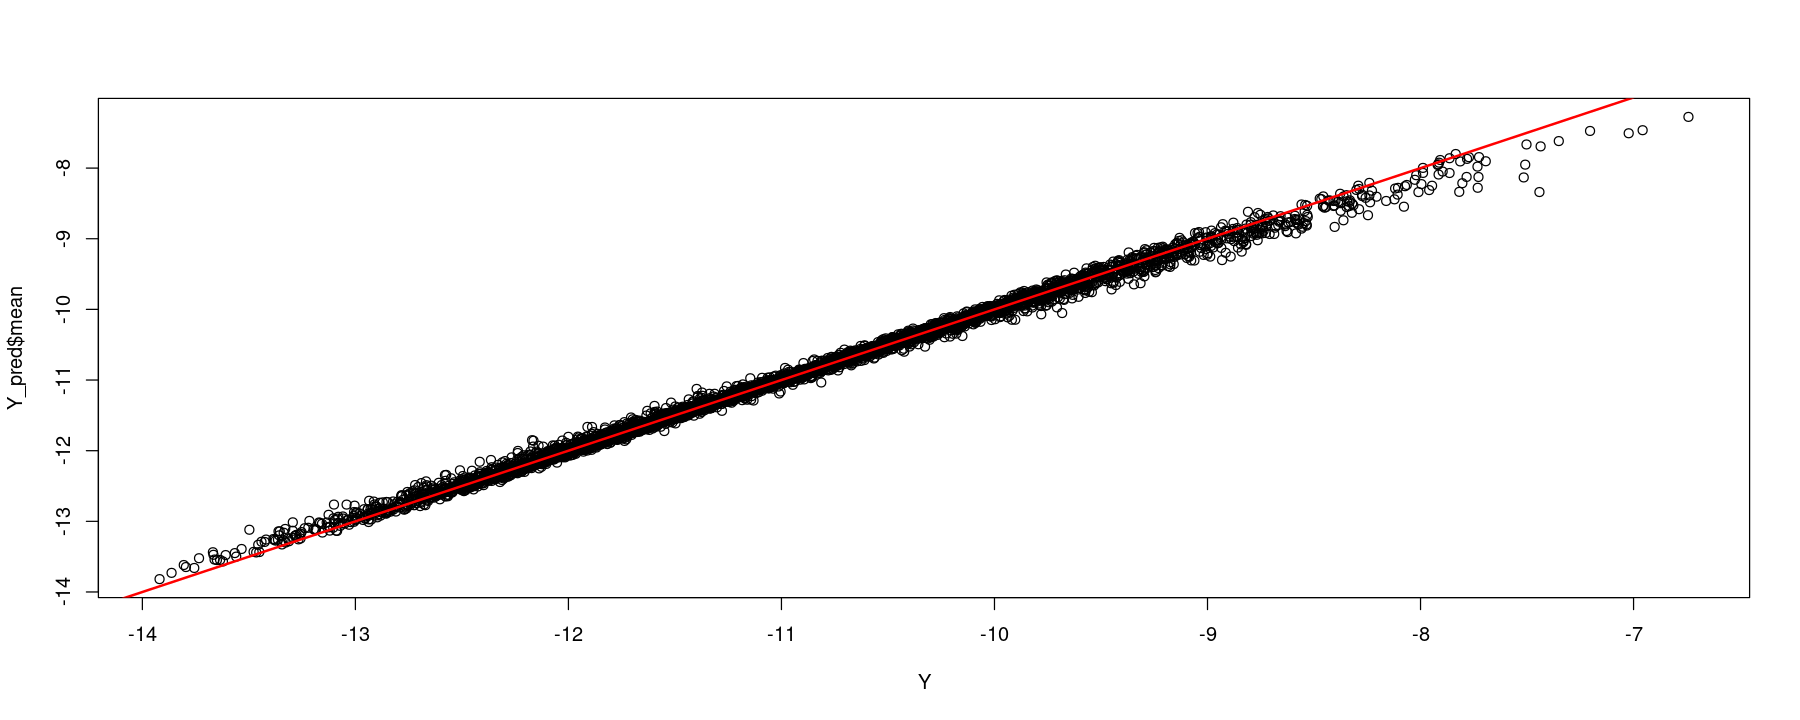

In [8]:
library(DiceKriging)
 

# For function km, a data.frame is required for argument design. Use:
train <- data.frame(X_train); names(train) <- floodInputNames
test <- data.frame(X); names(test) <- floodInputNames

# a code for the Q2 criterion is the following
Q2 <- function(y, yhat){
  1 - sum((y - yhat)^2) / sum((y - mean(y))^2)
}

Y_train = flood(X_train, ans = 1)
model= km(~1, design = train, response = Y_train , multistart = 5)
Y_pred = predict.km(model, test, type="UK")
Q2(Y, Y_pred$mean)
plot(Y, Y_pred$mean)
abline(0, 1, col = "red", lwd = 2)


Avec le critère $Q^2$, on obtient $99.6\%$ de ressemblance. Ce qui est confirmé par la figure puisque la moyenne des prédictions est sur la droite $y=x$. 

## Question 6

Compare the performance of the GP metamodel with a naive linear model (first-order polynomial). 

[1] 0.9780249

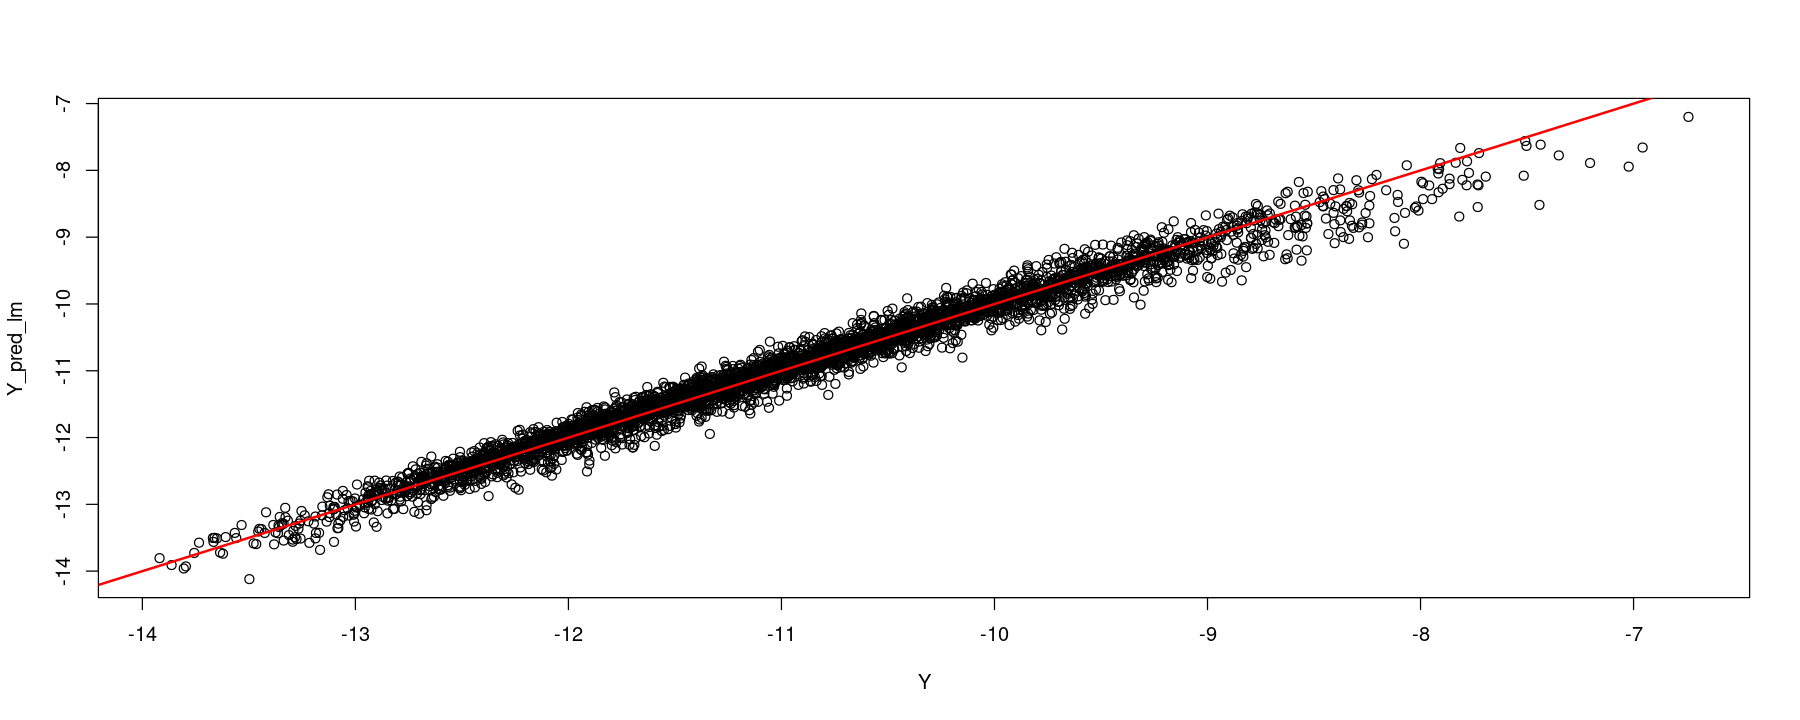

In [9]:
# Help for question 6
# Pour lm, it is recommended to use a data.frame pour data, 
# containing both Xtrain (train more precisely, cf. question 5) and Ytrain


# for prediction on a new dataset, both lm and km want data.frame 
# with the SAME input names as Xtrain (and not only matrices). 
# Thus, use
newdata <- data.frame(X)
names(newdata) <- floodInputNames


data = data.frame(y = Y_train, train)

model_lm = lm(y~., data = data)
Y_pred_lm = predict.lm(model_lm, newdata)
Q2(Y, Y_pred_lm)
plot(Y, Y_pred_lm)
abline(0, 1, col = "red", lwd = 2)


Nous remarquons que les modèles de GP et de régression linéaire naïve sont à peu près équivalents même si le metamodèle de GP reste meilleur ($2\%$ de différence pour les critères $Q^2$).

When the output is the cost, add $H_d^2$ to the covariates of this linear model (explain why it is reasonable). For that, plot the predictions versus the true values, and compute the $Q^2$ criterion as well.

[1] 0.6692581

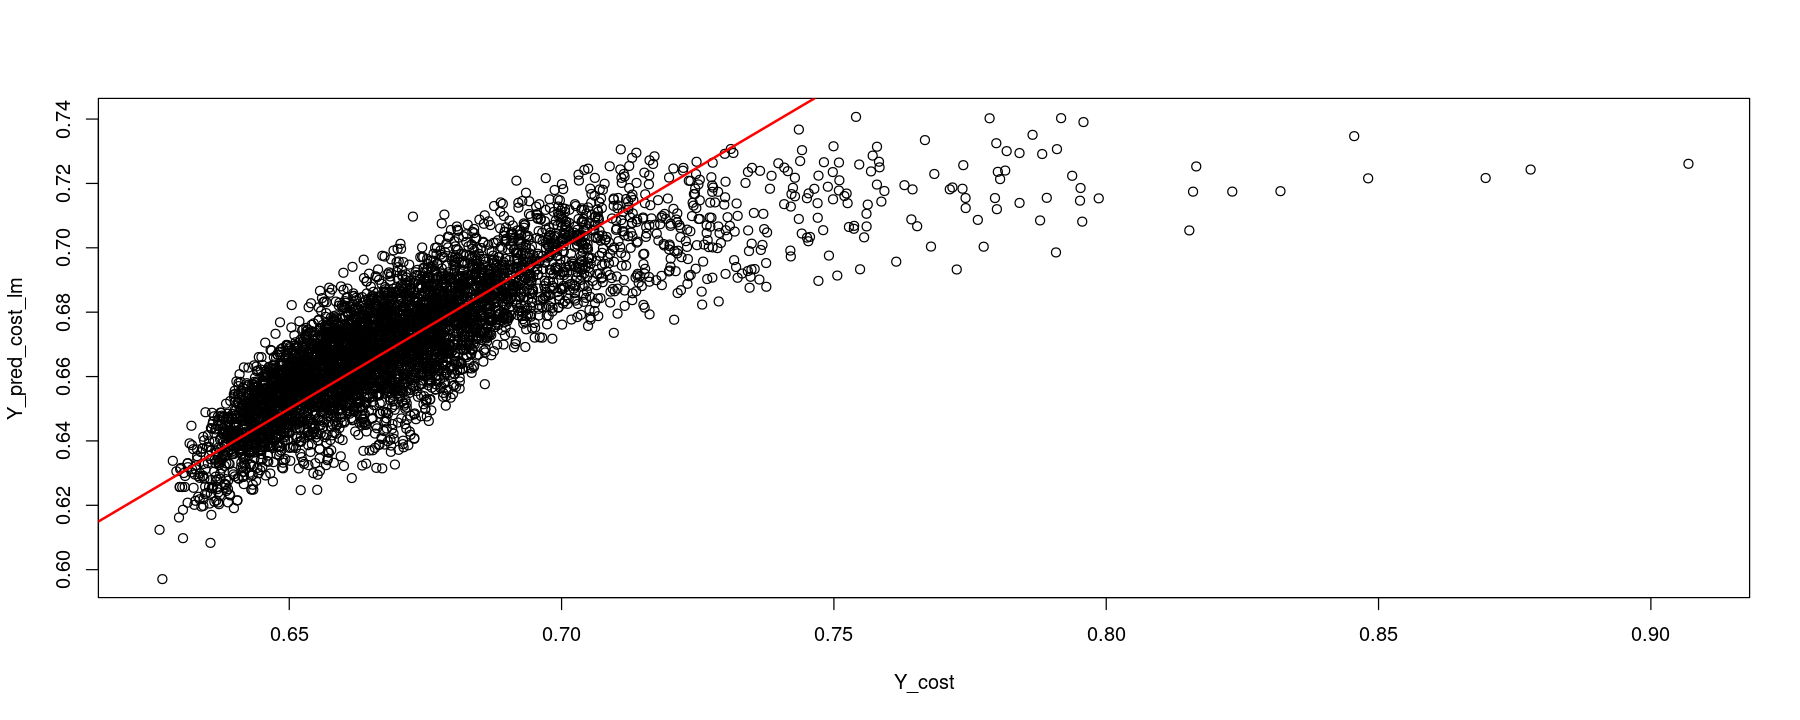

In [10]:
# We change the output to be a cost
MyOutput = 2
cost_train = flood(X_train, ans = MyOutput)
cost_data = data.frame(y = cost_train, train)
Y_cost = flood(X, ans = MyOutput)

# Without Hd
model_cost_lm = lm(y~., data = cost_data)
Y_pred_cost_lm = predict.lm(model_cost_lm, newdata)
Q2(Y_cost, Y_pred_cost_lm)
plot(Y_cost, Y_pred_cost_lm)
abline(0, 1, col = "red", lwd = 2)

Il est raisonnable d'ajouter $H_d^2$ aux covariables du modèle linéaire car le modèle semble avoir une forme qui parabolique et non linéaire en $H_d$.

[1] 0.7928205

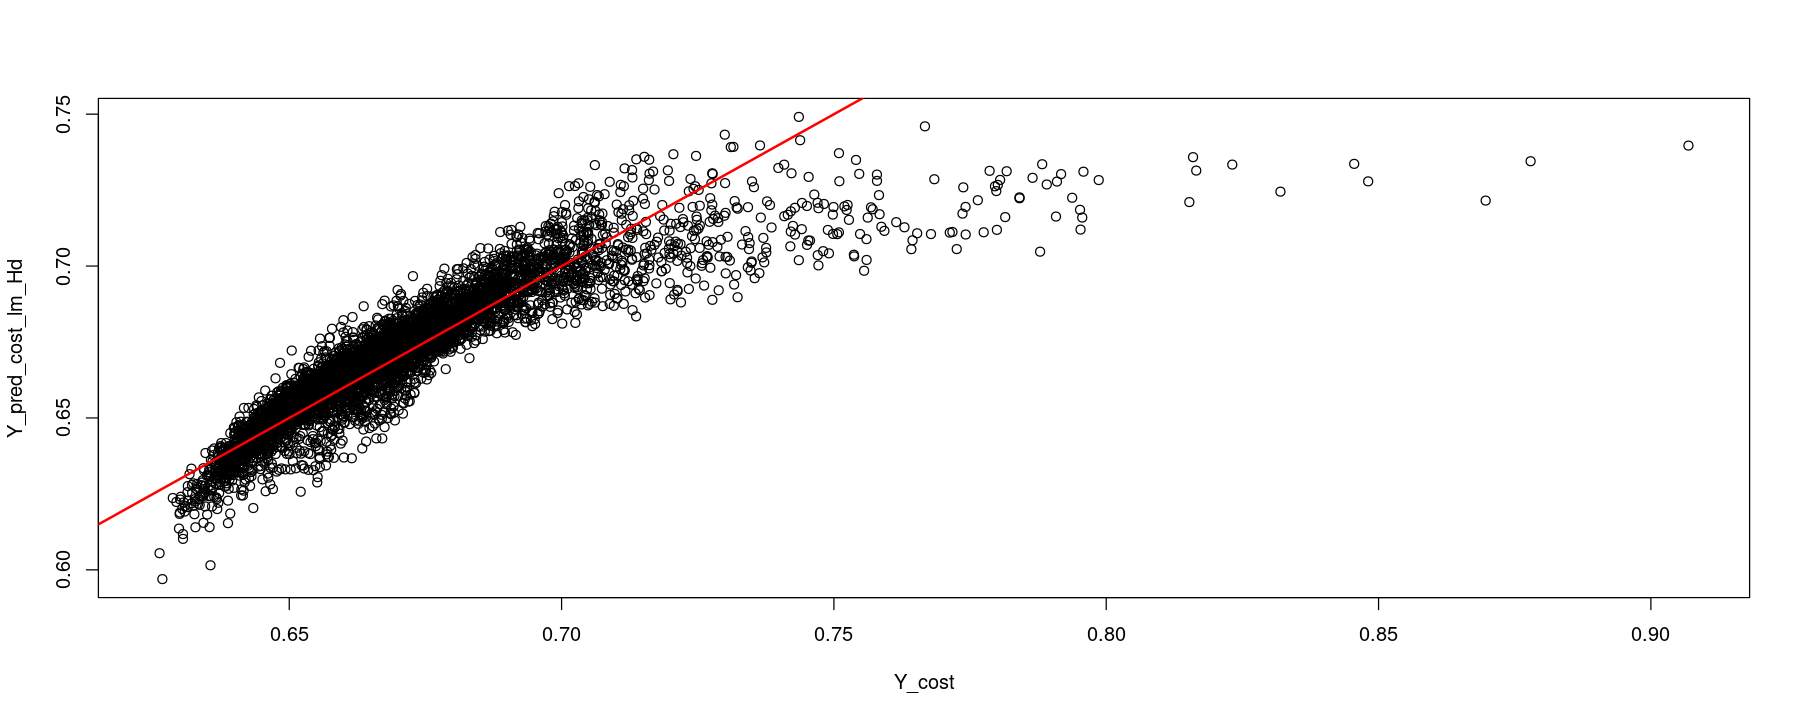

In [11]:
# With Hd
model_cost_lm_Hd = lm(y~.+I(Hd^2), data = cost_data)
Y_pred_cost_lm_Hd = predict.lm(model_cost_lm_Hd, newdata)

Q2(Y_cost, Y_pred_cost_lm_Hd)
plot(Y_cost, Y_pred_cost_lm_Hd)
abline(0, 1, col = "red", lwd = 2)

Nous remarquons avec le critère $Q^2$ que l'ajout de $H_d^2$ a permit d'ajouter $13\%$ de ressemblance entre les prédictions et les vraies valeurs.

### Question 7 

Perform a GSA on the mean of the GP metamodel (kriging mean) by doing questions 1-3 for it. Compare these results to the unlimited budget case.

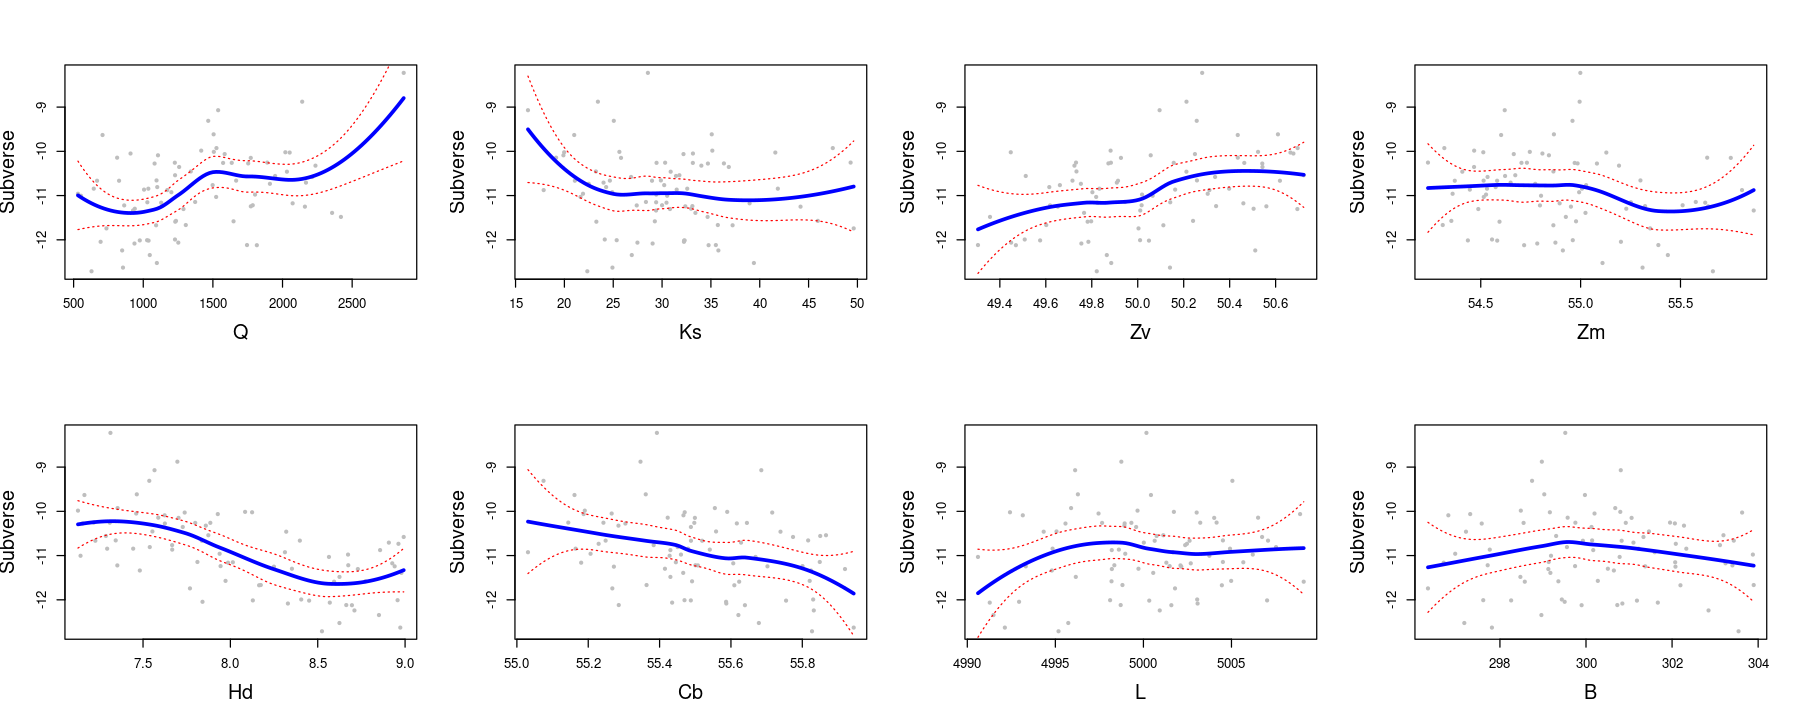

In [12]:
# help for question 7

# to plot the main effects, it can be useful to add the confidence intervals, because n is small.
# here is the code of question 2, for n = 80, with confidence intervals. To be adapted to your purpose !!
n <- 80 
set.seed(0); X <- floodSample(n); colnames(X) <- floodInputNames
Y <- flood(X, ans = myOutput)

par(mfrow = c(2, 4))
for (i in 1:8){
    plot(Y ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames[myOutput], 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- loess(Y ~ X[, i], se = TRUE)
    t <- seq(from = min(X[, i]), to = max(X[, i]), length = 100)
    predss <- predict(ss, t, se = TRUE)
    lines(t, predss$fit, col = "blue", lwd = 3)
    lines(t, predss$fit + 2 * predss$se, col = "red", lty = "dotted")
    lines(t, predss$fit - 2 * predss$se, col = "red", lty = "dotted")
}

# Use the following wraper, where m is the ouput of function km: m <- km(...), and Xnew is a test set.
krigingMean <- function(Xnew, m){
  pred <- predict(m, Xnew, "UK", se.compute = FALSE, checkNames = FALSE)
  return(as.numeric(pred$mean))  
}


On remarque que la fonction S a une forme moins lisse (ce n'est plus linéire partout) en fonction des varibles d'entrées dans le cas où n est faible. Le faible nombre d'échantillons peut fausser l'interprétation de ces courbes à causes des incertitudes (utilisation d'un intervalle de confiance nécessaire ici).
On peut noter cependant que les courbes de S en fonction des variables 𝑍𝑚, 𝐿 et 𝐵 sont à peu près constante comme à la question 1 à 3.

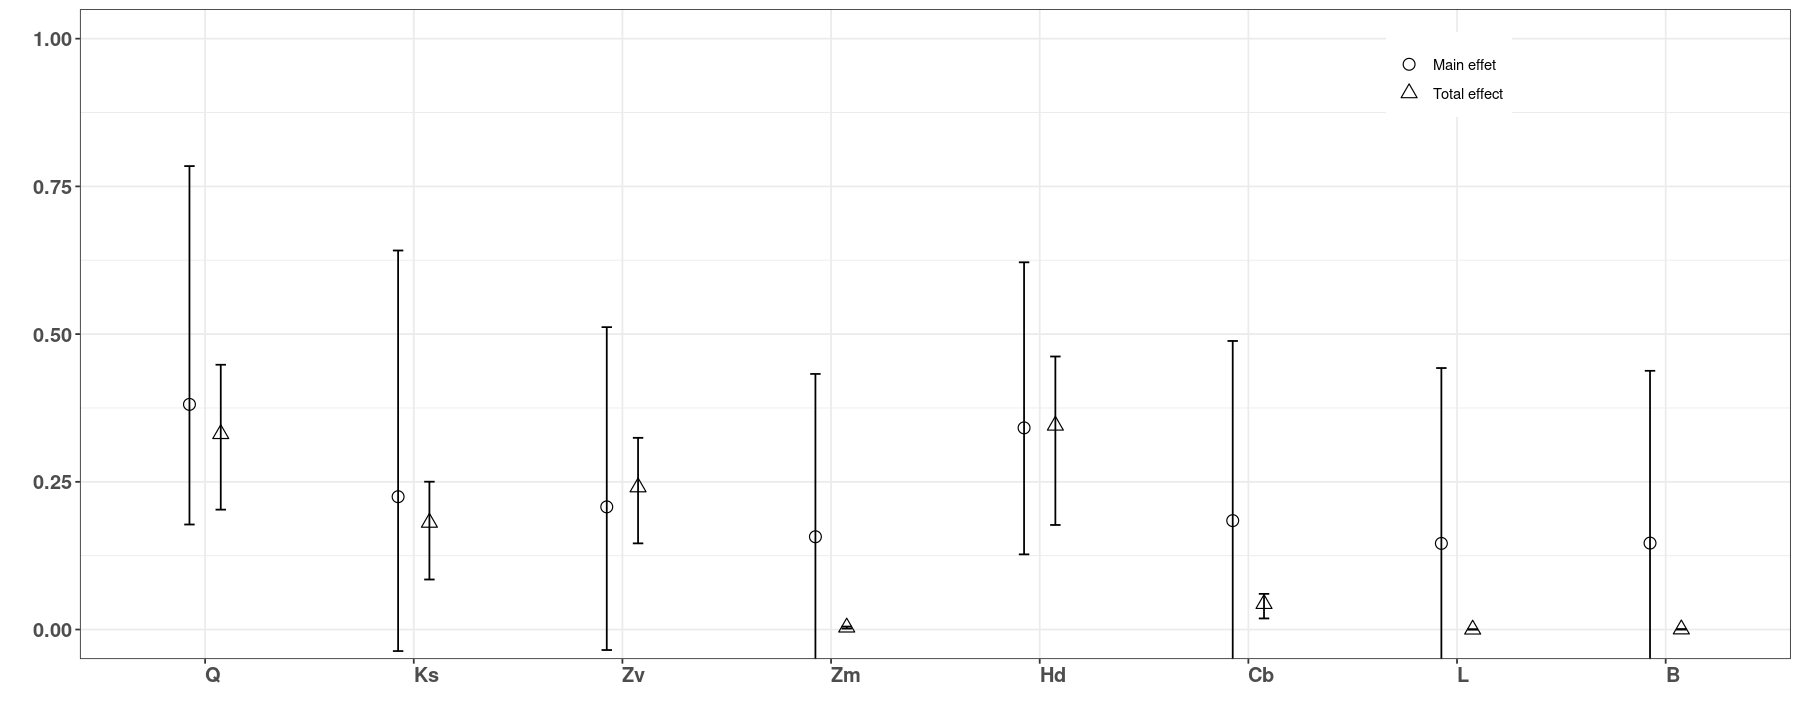

In [13]:
# we use a pick-freeze formula (Sobol Jansen), which requires two samples
X1 <- floodSample(n)
X2 <- floodSample(n)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis
SAresult <- soboljansen(model = krigingMean, X1, X2, nboot = 100, m = model)
totalIndex <- SAresult$T$original; names(totalIndex) <- floodInputNames
sobolIndex <- SAresult$S$original; names(sobolIndex) <- floodInputNames
ggplot(SAresult)

On remarque qu'on a beaucoup d'incertitude sur les main effect des variables d'entrées. Cela paraît cohérent car cette fois ci, nous avons qu'un faible nombre d'échantillons et aussi un budget limité. 

De plus, puisque les courbes de S en fonction des variables 𝑍𝑚, 𝐿 et 𝐵 sont à peu près constante, les effets totaux des variables 𝑍𝑚, 𝐿 et 𝐵 sont proche de 0. Mais à cause des incertitudes (notamment dans le main effect), il est préférable de ne pas supprimer de variables d'entrées.

On observe également qu'il y a des interactions entre les différentes variables (Q et H$_d$ sont en interaction et $K_s$ et $Z_v$ sont en interaction également).

Finalement, on remarque que certaines variables peuvent être supprimées car leurs total effect est proche de 0, ce sont les variables Zm, L et B.

## Metamodeling improvements and physics-informed Gaussian process

To improve the metamodeling step, we bring some information contained in the equations defining the subverse and the cost.

### Question 8
Consider the output "subverse". Play with function 'km' in order to add a linear trend to the GP model. Check that this model outperforms the basic GP, by plotting the prediction on the test set (here $X$) versus the true value, and computing the $Q^2$ criterion. Redo question 7 for this model. Comment?

Le chargement a nécessité le package : igraph


Attachement du package : ‘igraph’


Les objets suivants sont masqués depuis ‘package:stats’:

    decompose, spectrum


L'objet suivant est masqué depuis ‘package:base’:

    union




[1] 0.9544005

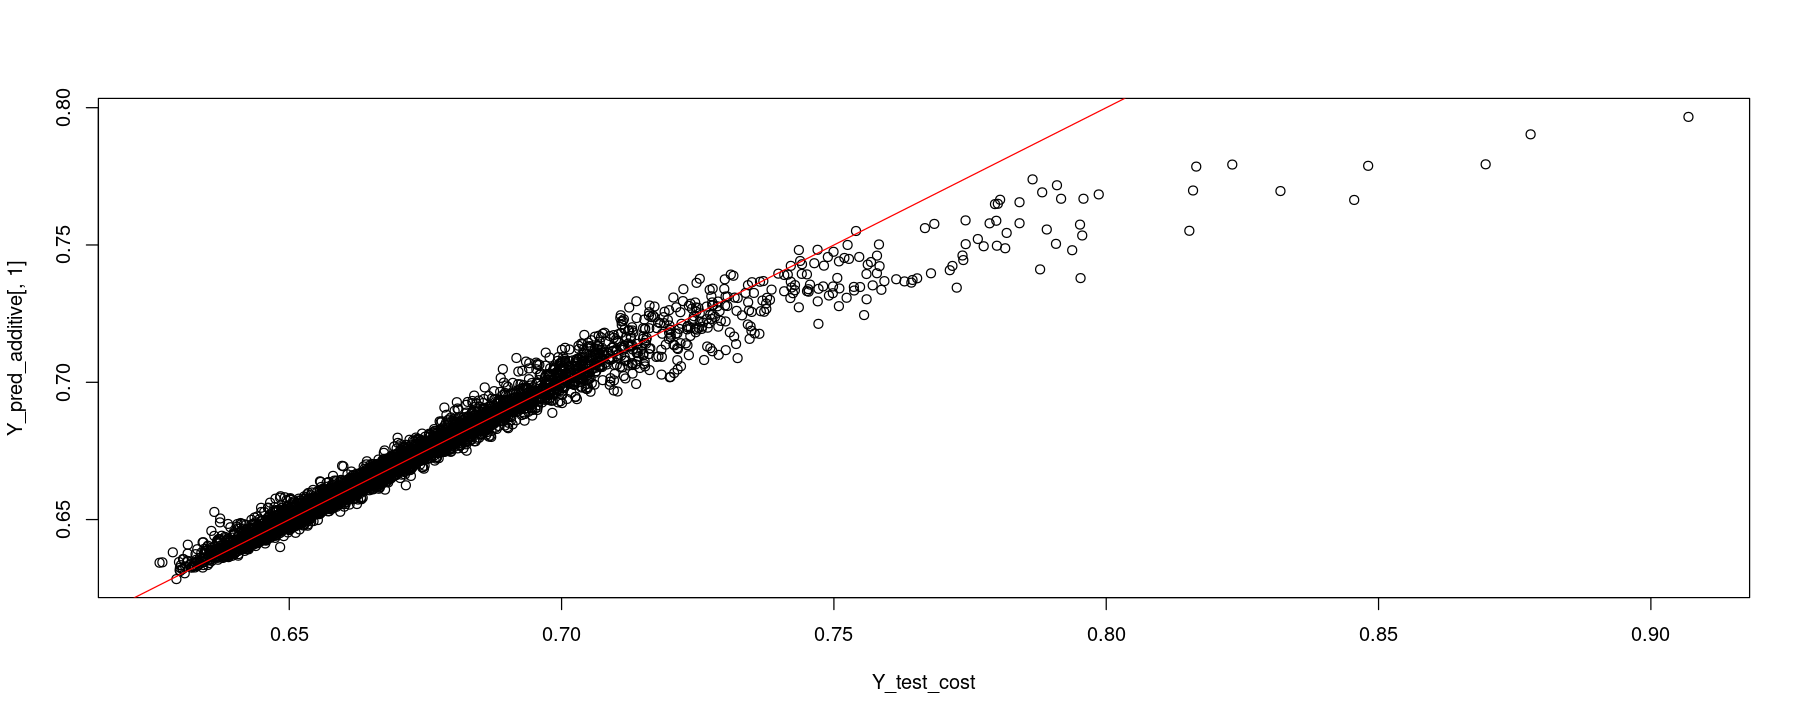

In [14]:
library(fanovaGraph)

N <- 5000
set.seed(0); X <- floodSample(N); colnames(X) <- floodInputNames
Y_test_cost = flood(X, ans = 2)
cl_list =  list(c(1:8),c(5))
krig_additive = kmAdditive(train, cost_train, cl = cl_list)
Y_pred_additive = predictAdditive(X, train, cost_train, krig_additive, cl=cl_list)
plot(Y_test_cost, Y_pred_additive[, 1])
abline(0, 1, col = "red")
Q2(Y_test_cost, Y_pred_additive)


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  10.39941 3.875 
  - best initial criterion value(s) :  449.9389 444.1151 441.4549 440.5538 438.6636 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -449.94  |proj g|=       2.0714
At iterate     1  f =      -450.02  |proj g|=        1.8632
At iterate     2  f =      -450.35  |proj g|=       0.96245
At iterate     3  f =      -450.44  |proj g|=       0.35334
At iterate     4  f =      -450.45  |proj g|=      0.041656
At iterate     5  f =      -450.45  |proj g|=     0.0082482
At iterate     6  f =      -450.45  |proj g|=     0.0018752

iterations 6
function evaluations 10
segments explored during Cauchy searches 6
BFGS updates skipped 0
acti

[1] 0.9734164

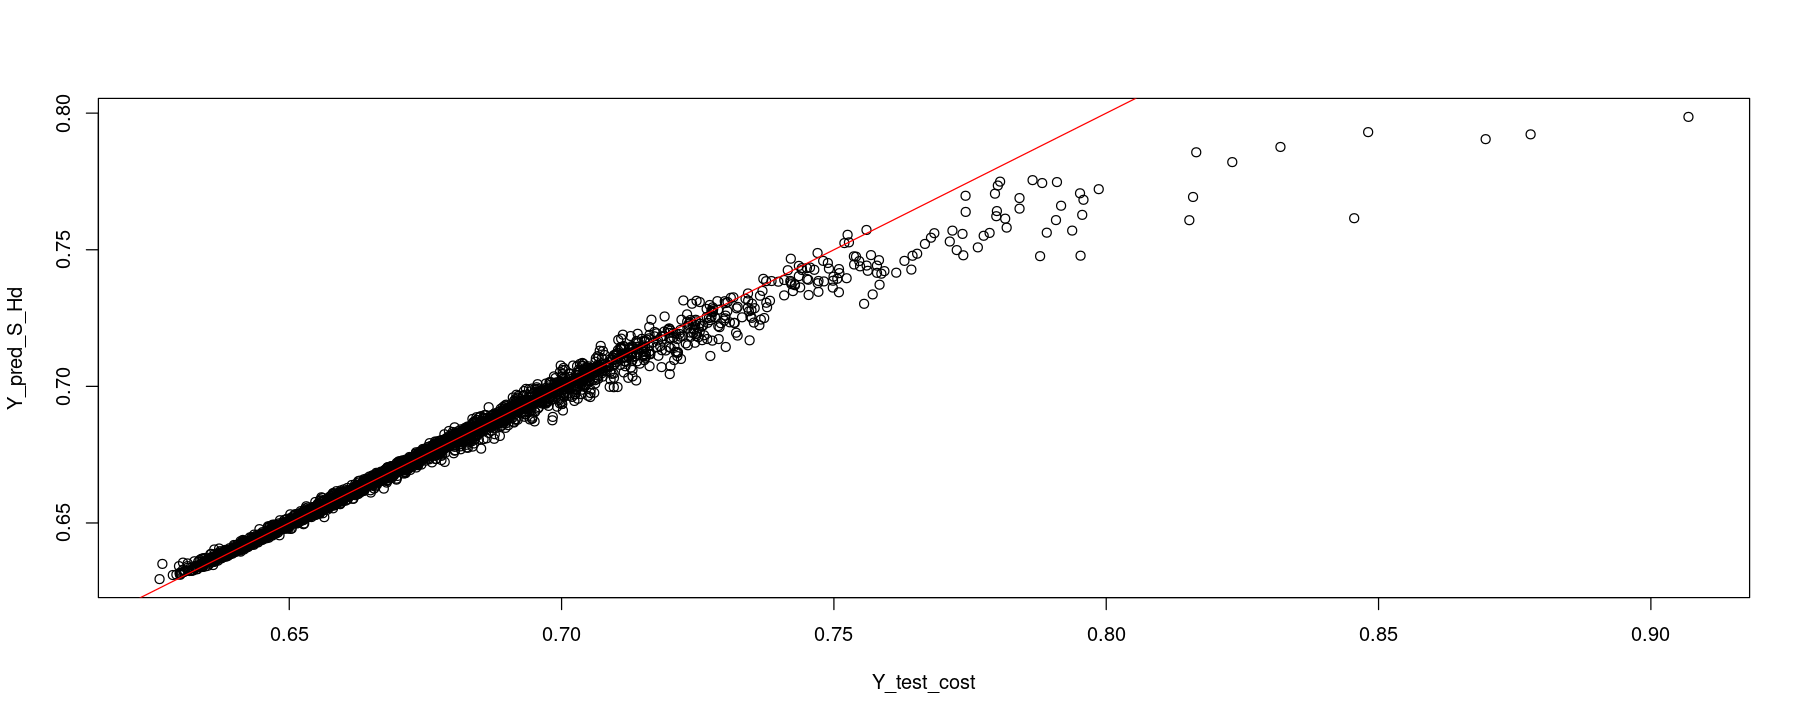

In [15]:
## new GP depending on S and Hd
model_S_predict = predict.km(model, train, type="UK")$mean
data_S_Hd = data.frame(S = model_S_predict, train[5])
model_km_S_Hd = km(~ 1, design = data_S_Hd, response = cost_train, multistart = 5)

S_pred_test = predict.km(model, test, type="UK")$mean
data_S_Hd_test = data.frame(S = S_pred_test, test[5])
Y_pred_S_Hd = predict.km(model_km_S_Hd, data_S_Hd_test, type="UK")$mean
plot(Y_test_cost, Y_pred_S_Hd)
abline(0, 1, col = "red")
Q2(Y_test_cost, Y_pred_S_Hd)

Nous pouvons remarquer que l'ajout d'une tendance linéaire dans le modèle  améliore la précision des estimations. Cela se manifeste par un critère $Q^2$ plus proche de 1, ce qui indique moins d'erreurs.

Cependant, cette amélioration a un impact négligeable, voire inexistant, sur l'analyse globale de la sensibilité (GSA) par rapport au modèle de processus gaussien sans tendance linéaire.


### Question 9 
Knowing the equation of the ouput "cost", we see that a suitable GP should have the form 
$$Y(S, H_d) = Y_1(S) + Y_2(H_d)$$
Assuming that $Y_1, Y_2$ are independent Gaussian processes with kernels $k_1, k_2$, what form should have the kernel of $Y$? Estimate this new GP with function "kmAdditive", from the R package fanovaGraph, still using $Xtrain$ as a desing of experiments. Check that this model outperforms the basic GP. Compare also with a GP depending on $S$ and $H_d$. However, explain why it seems difficult to use this approach for global sensitivity analysis with respect to the original variables.

Une première idée serait de prendre pour noyau de Y : 
$k_y = k1+k2$ avec k1 le noyau de Y1 et k2 le noyau de y2. Vérifions cela en calculant la covariance : 

$$ k_y = Cov(Y(S,Hd), Y(S',Hd')) 
       = Cov(Y_1(S)+Y_2(Hd), Y_1(S')+Y_2(Hd')) 
       = Cov(Y_1(S),Y_1(S'))+ Cov(Y_1(S),Y_2(Hd'))+Cov(Y_2(Hd),Y_1(S'))+Cov(Y_2(Hd),Y_2(Hd')) 
       = k1+k2 $$ 
car $Y_1$ indépendant de $Y_2$. 

On peut donc prendre comme noyau $k1+k2$

In [17]:

N <- 5000
myOutput <- 1
set.seed(0); X <- floodSample(N); colnames(X) <- floodInputNames
Y_train = flood(X_train, ans = 2)
Y_test = flood(X, ans = 2)
test <- data.frame(X); names(test) <- floodInputNames
train <- data.frame(X_train); names(train) <- floodInputNames

cl <- list(c(1:8),c(5))
Km_add = kmAdditive(train, Y_train, cl = cl)
Y_pred_add = krigingMeanAdditive(X, train, Y_train, Km_add, cl=cl) #Ici on définit le noyau en fonction des cliques donc de S et de Hd


[1] 0.9544005

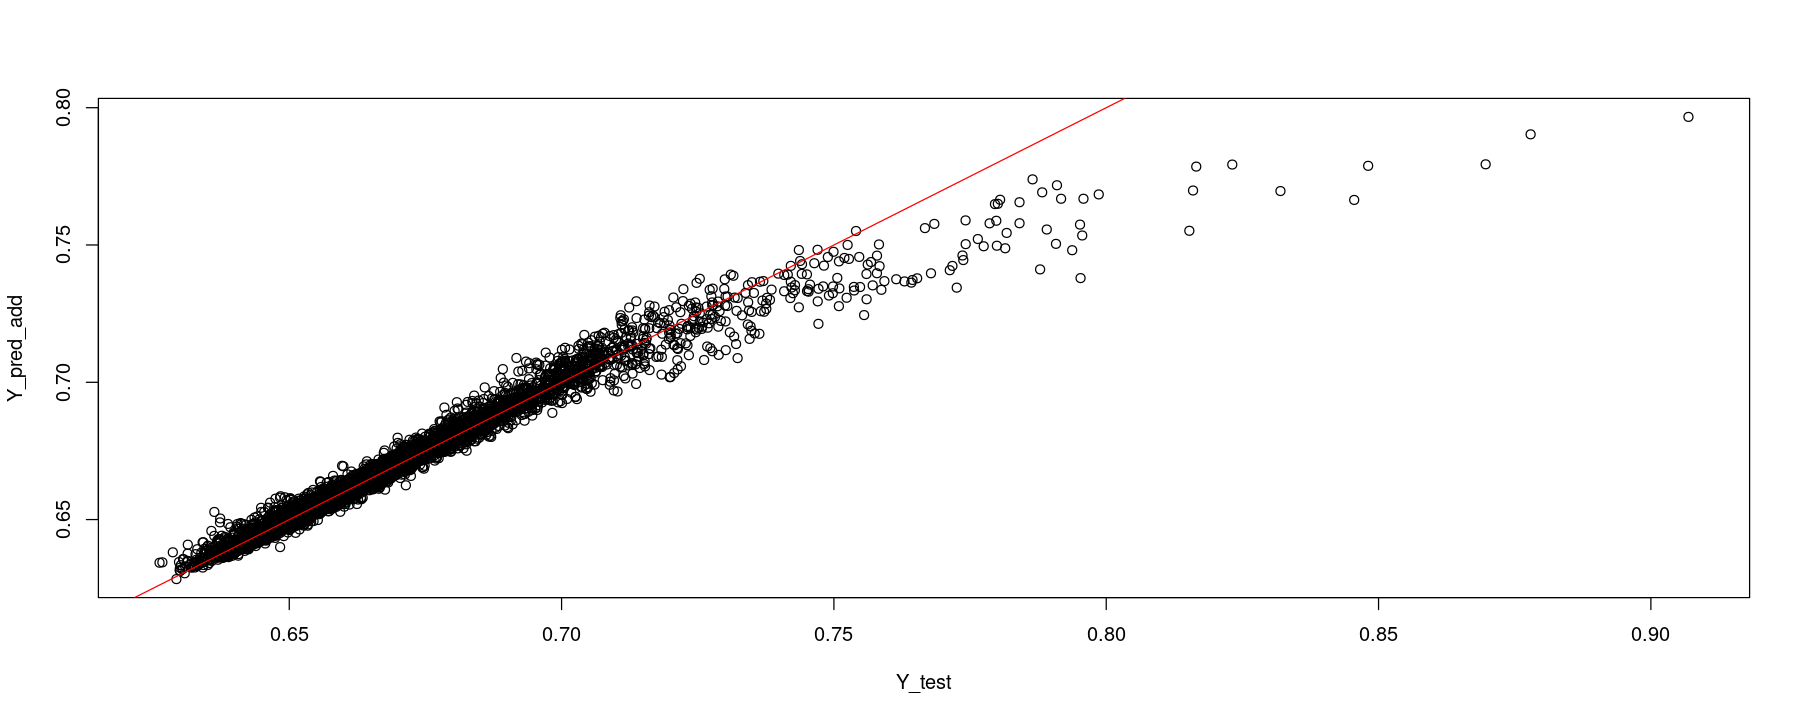

In [22]:
##Affichage 
plot(Y_test, Y_pred_add)
abline(0, 1, col = "red")
Q2(Y_test, Y_pred_add)

Ici on remarque que le Q2 est meilleur que ce qu'on avait obtenu à la question 6 (environ 0.95 contre 0.70). De plus, on peut confirmer cela sur le graphique puisqu'on voit que les points sont plus sur la droite. 
Il semblerait donc qu'on soit plus performant que ce que nous avions à la question 6.


### Essai d'un modèle en prenant S et Hd 

In [23]:
S = predict.km(model, train, type="UK")$mean
dataset_S_Hd_train = data.frame(S = S, train[5])
model_S_Hd = km(~ 1, design = dataset_S_Hd_train, response = Y_train, multistart = 5)

S_test = predict.km(model, test, type="UK")$mean
dataset_S_Hd_test = data.frame(S = S_test, test[5])
Y_pred_S_Hd = predict.km(model_S_Hd, dataset_S_Hd_test, type="UK")$mean



optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  10.39941 3.875 
  - best initial criterion value(s) :  449.9389 444.1151 441.4549 440.5538 438.6636 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -449.94  |proj g|=       2.0714
At iterate     1  f =      -450.02  |proj g|=        1.8632
At iterate     2  f =      -450.35  |proj g|=       0.96245
At iterate     3  f =      -450.44  |proj g|=       0.35334
At iterate     4  f =      -450.45  |proj g|=      0.041656
At iterate     5  f =      -450.45  |proj g|=     0.0082482
At iterate     6  f =      -450.45  |proj g|=     0.0018752

iterations 6
function evaluations 10
segments explored during Cauchy searches 6
BFGS updates skipped 0
acti

[1] 0.9734164

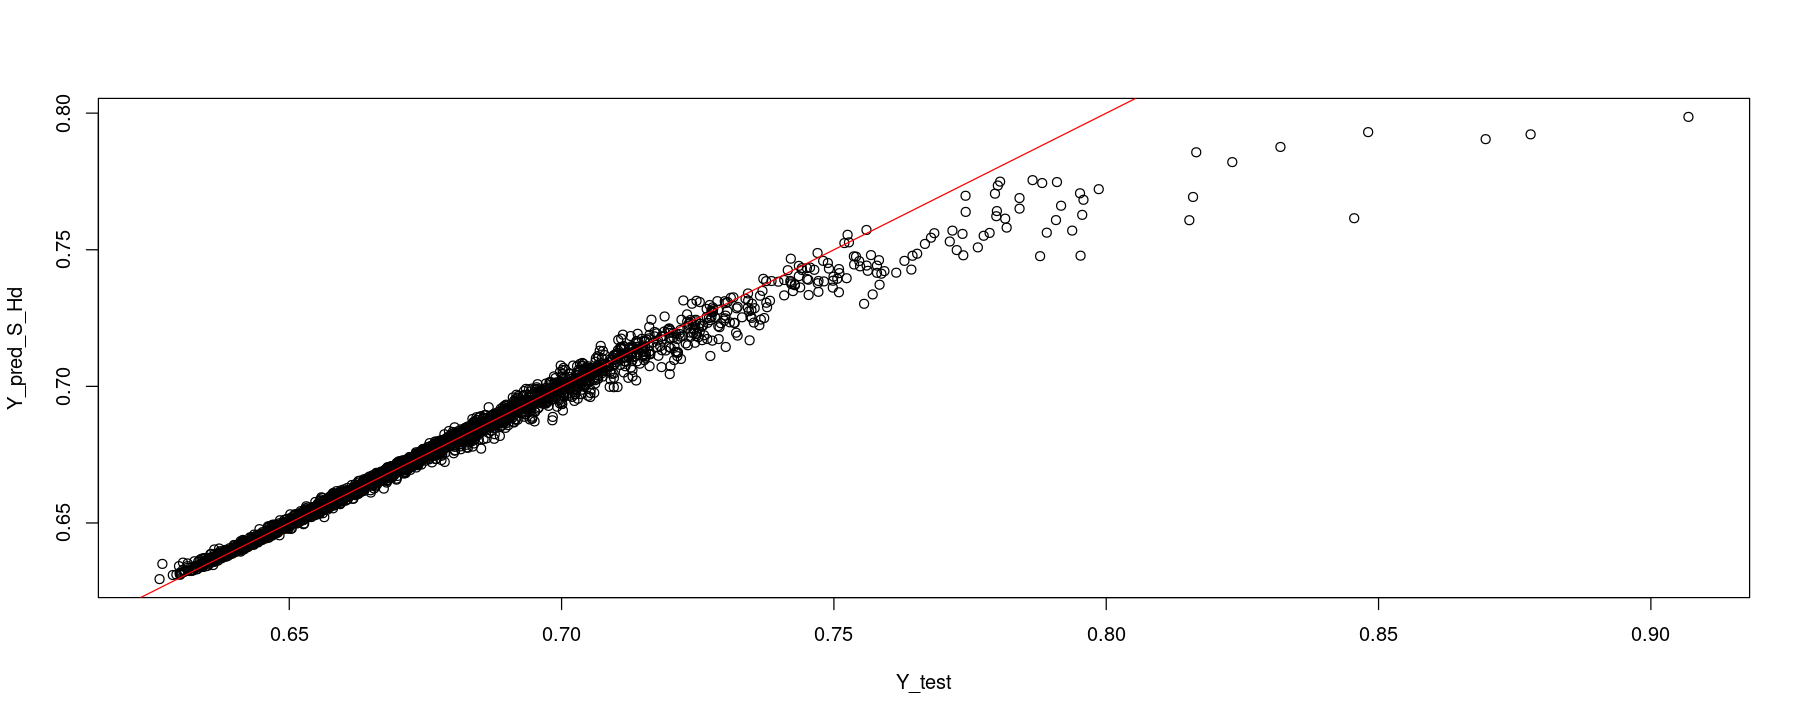

In [24]:
##Affichage 
plot(Y_test, Y_pred_S_Hd)
abline(0, 1, col = "red")
Q2(Y_test, Y_pred_S_Hd)

Maintenant on remarque que le Q2 est encore meilleur que ce que nous avons obtenu avec le modèle précédent (on obtient un Q2 d'environ 0.97). La courbe montre aussi ce bon résultat car beaucoup de points sont sur la droite, on remarque cependant qu'il y a encore quelques points qui ne sont pas sur la droite (les points en haut à droite). 

Il semble difficile d'utiliser cette approche dans l'analyse de sensibilité car S dépend de toutes les variables y compris Hd. Il va être complexe de détecter les effets de Hd sur les variables de S 

## At least one theoretical computation

## Question 10 :
For the output "S", compute theoretically the main effect with respect to the variable $H_d$. Compare with 3)a). Same question for $C_b$.



On a :
\begin{equation}
S = \left(\frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} + Z_v - H_d - C_b
\end{equation}
- Et pour la la hauteur du barrage $H_d$, on a:


\begin{equation}
S_{H_d}(H_d) = \mathbb{E}[S(X) | H_d] - S_0 = \mathbb{E}[S(X) | H_d] - \mathbb{E}[S(X)]
\end{equation}


Donc par linéarité de l'espérance, 
\begin{equation}
\mathbb{E}[S(X)] = \mathbb{E}\left[ \left( \frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} \right] + \mathbb{E}[Z_v] - \mathbb{E}[H_d] - \mathbb{E}[C_b]
\end{equation} 

Et par indépendance de Hd avec les autres variables,
\begin{equation}
\begin{split}
\mathbb{E}[S(X) | H_d] & = \mathbb{E}\left[ \left( \frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} | H_d\right] + \mathbb{E}[Z_v | H_d] - H_d - \mathbb{E}[C_b | H_d] \\
& = \mathbb{E}\left[\frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right]^{0.6} + \mathbb{E}[Z_v] - H_d - \mathbb{E}[C_b]\\
\end{split}
\end{equation}

D'où 
\begin{equation}
\begin{split}
S_{H_d}(H_d) & = \mathbb{E}[S(X) | H_d] - \mathbb{E}[S(X)] \\ & 
= -H_d + \mathbb{E}[H_d] \\& 
= -H_d + \int_{-\infty}^{\infty} x f_{\mathcal H_d}(x) dx \\ & 
= -H_d + \int_{7}^{9} \frac{x}{2} dx \\ &
= -H_d + \frac{9^2-7^2}{4} \\ & = -H_d + 16
\end{split}
\end{equation}
On peut observer que $H_d$ a un effet principal négatif sur $S$ tandis qu'à la question 3.a, nous avions supposé qu'il n'avait aucun effet sur S.



- De même, pour la variable $C_b$ représentant le niveau du bord de l'eau, on a :
\begin{equation}
\begin{split}
S_{C_b}(C_b) & = \mathbb{E}[S(X) | C_b] - \mathbb{E}[S(X)] \\ & 
= -C_b + \mathbb{E}[C_b] \\& 
= -C_b + \int_{-\infty}^{\infty} x f_{\mathcal C_b}(x) dx \\ & 
= -C_b + \int_{55}^{56} 2 x \left(1 - \left|x - 55\right|\right) (x) dx \\ & 
= -C_b + 2\int_{0}^{1} (2(u + 55)u) \, du + 2\int_{55}^{56} -2x \, dx \\ & 
= -C_b + \left(\frac{4}{3} + 110\right) + -4\left(\frac{111}{2}\right) \\ & 
= -C_b + \left(\frac{4}{3} + 110\right) - 222 \\ & 
= -C_b -\frac{334}{3}
\end{split}
\end{equation}
De même que pour $H_d$, on peut observer que $C_b$ a un effet principal négatif sur $S$ tandis qu'à la question 3.a, nous avions supposé qu'il n'avait aucun effet sur S.